In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import astro530

In [2]:
reload(astro530)

<module 'src.astro530' from 'C:\\Users\\xkncr\\Documents\\PSU\\Astro530\\src\\astro530.py'>

In [3]:
partition = astro530.partition

In [4]:
openfile = open("data/VALIIIC_sci_e.txt","r")
openlines = openfile.readlines()
openfile.close()

In [5]:
table = []
for i,line in enumerate(openlines):
    data = line.split()
    if len(data) == 0: continue
    if data[0] == "#":
        if i == 0:
            header = data[1:]
        print(line)
        continue
    table.append(data)

# h     m     tau_500     T     V     n_H     n_e     Ptotal  Pgas/Ptotal  rho

# (km) (g cm )            (K)  (km/s) (cm^-3) (cm^-3) (dyn cm^-2)          (g cm^-3)



In [6]:
table = np.array(table,dtype=float)

In [7]:
a = [0,1,2,3,4]
a[1:]
type(a[:])

list

In [8]:
df = pd.DataFrame(table,columns = header)
df

,h,m,tau_500,T,V,n_H,n_e,Ptotal,Pgas/Ptotal,rho
0,2543.0,0.000005,0.000000e+00,447000.0,11.28,1.005000e+09,1.205000e+09,0.1440,0.9896,2.349000e-15
1,2298.0,0.000005,3.712000e-08,141000.0,9.87,3.205000e+09,3.839000e+09,0.1470,0.9752,7.494000e-15
2,2290.0,0.000005,3.969000e-08,89100.0,9.82,5.041000e+09,5.961000e+09,0.1472,0.9614,1.179000e-14
3,2280.0,0.000005,4.491000e-08,50000.0,9.76,9.038000e+09,9.993000e+09,0.1477,0.9318,2.113000e-14
4,2274.0,0.000005,4.952000e-08,37000.0,9.73,1.201000e+10,1.318000e+10,0.1481,0.9102,2.808000e-14
5,2271.0,0.000005,5.234000e-08,32000.0,9.71,1.378000e+10,1.498000e+10,0.1483,0.8976,3.222000e-14
6,2267.0,0.000005,5.657000e-08,28000.0,9.70,1.567000e+10,1.677000e+10,0.1487,0.8840,3.665000e-14
7,2263.0,0.000005,6.124000e-08,25500.0,9.68,1.718000e+10,1.812000e+10,0.1491,0.8738,4.017000e-14
8,2255.0,0.000005,7.110000e-08,24500.0,9.64,1.797000e+10,1.881000e+10,0.1500,0.8698,4.203000e-14
9,2230.0,0.000006,1.030000e-07,24200.0,9.49,1.862000e+10,1.943000e+10,0.1530,0.8718,4.355000e-14


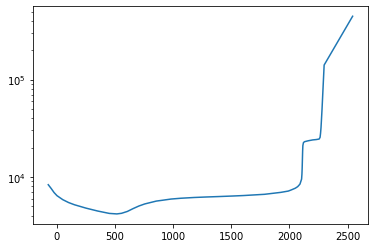

In [9]:
plt.yscale("log")
plt.plot(df["h"],df["T"])

In [10]:
Pe = ((df["n_e"]*df["T"]).to_numpy()*const.k_B.cgs).value
#partition(species="H",temp=df["T"])

In [11]:
Pe

array([7.43665874e-02, 7.47343923e-02, 7.33297338e-02, 6.89841273e-02,
       6.73287291e-02, 6.61827905e-02, 6.48297544e-02, 6.37942677e-02,
       6.36265188e-02, 6.49189444e-02, 6.65693722e-02, 6.87839332e-02,
       7.04641830e-02, 7.07030353e-02, 6.96426969e-02, 6.69200570e-02,
       5.61424348e-02, 5.22223581e-02, 4.85953932e-02, 4.42685221e-02,
       4.26902193e-02, 4.14705816e-02, 4.01033249e-02, 3.87257686e-02,
       3.81380539e-02, 3.85951040e-02, 4.36723164e-02, 5.33927343e-02,
       5.67788035e-02, 6.58956155e-02, 6.42870489e-02, 6.88449579e-02,
       7.79624325e-02, 8.51573948e-02, 8.33497111e-02, 8.29990953e-02,
       6.44274886e-02, 5.32239085e-02, 5.27988481e-02, 6.78594506e-02,
       1.01209718e-01, 1.43644793e-01, 2.63117459e-01, 6.84270354e-01,
       1.76470689e+00, 4.63148095e+00, 8.02851535e+00, 1.71096651e+01,
       5.70206104e+01, 1.47588203e+02, 4.88038021e+02, 1.38303476e+03])

In [12]:
const.k_B.cgs

<Quantity 1.380649e-16 erg / K>

In [13]:
n_p=astro530.saha_LTE(species="H",temp=df["T"],Pe=Pe)*df["n_H"].to_numpy()

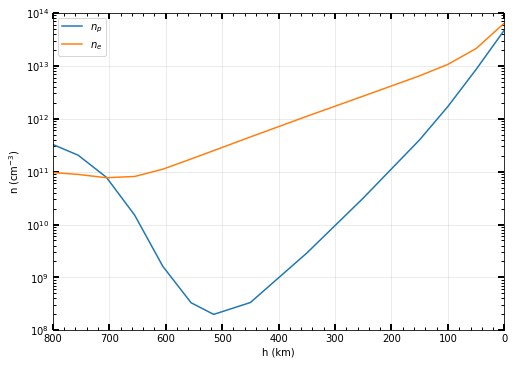

In [14]:
fig, ax = plt.subplots(figsize = (7,5), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/18b.pdf"
#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax.set_yscale("log")
ax.set_xlim([800,0])
ax.set_ylim([10**8,10**14])
ax.plot(df["h"],n_p,label=r"$n_p$")
ax.plot(df["h"],df["n_e"],label=r"$n_e$")

ax.set_xlabel("h (km)")
ax.set_ylabel(r"n (cm$^{-3}$)")

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [15]:
h800 = df.loc[df["h"]<900].loc[df["h"]>740]
h800

,h,m,tau_500,T,V,n_H,n_e,Ptotal,Pgas/Ptotal,rho
35,855.0,0.002632,0.000016,5650.0,1.53,8.135000e+13,1.064000e+11,72.1,0.9691,1.902000e-10
36,755.0,0.005577,0.000025,5280.0,1.23,1.864000e+14,8.838000e+10,152.8,0.9784,4.358000e-10


In [16]:
pe = h800["n_e"].to_numpy()*h800["T"].to_numpy()*(const.k_B.cgs).value
T_arr = np.linspace(4500,5600,20)
prot=astro530.saha_LTE(species="H",temp=T_arr,Pe=pe.mean())*(h800["n_H"].to_numpy()).mean()
res = abs(prot-10**11)

<function matplotlib.pyplot.show(close=None, block=None)>

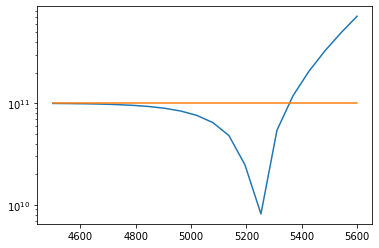

In [17]:
plt.plot(T_arr,res)
plt.plot([4500,5600],[10**11,10**11])
plt.yscale("log")
plt.show

In [18]:
minr= res[0]
mint = T_arr[0]
for i,r in enumerate(res):
    if r < minr:
        minr = r
        mint = T_arr[i]

In [19]:
# PeH=astro530.calc_Pe(species="H",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)
# PeFe=astro530.calc_Pe(species="Fe",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)
# PeMg=astro530.calc_Pe(species="Mg",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)
# PeSi=astro530.calc_Pe(species="Si",T=df["T"].to_numpy()*u.K,Pg=df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2)

In [20]:
# n_e = df["n_e"].loc[df["h"]<900].loc[df['h']>=-1]
# T = df["T"].loc[df["h"]<900].loc[df['h']>=-1].to_numpy()*u.K
# Pg = df["Pgas/Ptotal"].loc[df["h"]<900].loc[df['h']>=-1].to_numpy()*df["Ptotal"]
#.loc[df["h"]<900].loc[df['h']>=-1].to_numpy()*u.dyn/u.cm**2
n_e = df["n_e"].to_numpy()
T = df["T"].to_numpy()*u.K
Pg = df["Pgas/Ptotal"].to_numpy()*df["Ptotal"].to_numpy()*u.dyn/u.cm**2

In [21]:
# PeH = []
# PeFe = []
# PeMg = []
# PeSi = []
# for i in range(len(T)):
#     print(i)
#     PeH.append(astro530.true_Pe(species="H",T=T[i],Pg=Pg[i],tol=1e-3)[0].value)
#     PeFe.append(astro530.true_Pe(species="Fe",T=T[i],Pg=Pg[i],tol=1e-3)[0].value)
#     PeMg.append(astro530.true_Pe(species="Mg",T=T[i],Pg=Pg[i],tol=1e-3)[0].value)
#     PeSi.append(astro530.true_Pe(species="Si",T=T[i],Pg=Pg[i],tol=1e-3)[0].value)

In [22]:
Pe_true = []
spec = ["H","He","Fe","Mg","Si"]
for i in range(len(T)):
    print(i)
    Pe_true.append(astro530.true_Pe(species=spec,T=T[i],Pg=Pg[i],tol=1e-3,single=True).value)
Pe_true = np.array(Pe_true)*u.dyn/u.cm**2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


In [23]:
# Pe_true = Pe*u.dyn/u.cm**2
Pe

array([7.43665874e-02, 7.47343923e-02, 7.33297338e-02, 6.89841273e-02,
       6.73287291e-02, 6.61827905e-02, 6.48297544e-02, 6.37942677e-02,
       6.36265188e-02, 6.49189444e-02, 6.65693722e-02, 6.87839332e-02,
       7.04641830e-02, 7.07030353e-02, 6.96426969e-02, 6.69200570e-02,
       5.61424348e-02, 5.22223581e-02, 4.85953932e-02, 4.42685221e-02,
       4.26902193e-02, 4.14705816e-02, 4.01033249e-02, 3.87257686e-02,
       3.81380539e-02, 3.85951040e-02, 4.36723164e-02, 5.33927343e-02,
       5.67788035e-02, 6.58956155e-02, 6.42870489e-02, 6.88449579e-02,
       7.79624325e-02, 8.51573948e-02, 8.33497111e-02, 8.29990953e-02,
       6.44274886e-02, 5.32239085e-02, 5.27988481e-02, 6.78594506e-02,
       1.01209718e-01, 1.43644793e-01, 2.63117459e-01, 6.84270354e-01,
       1.76470689e+00, 4.63148095e+00, 8.02851535e+00, 1.71096651e+01,
       5.70206104e+01, 1.47588203e+02, 4.88038021e+02, 1.38303476e+03])

In [24]:
AFe = astro530.find_Abundance(species="Fe")
AMg = astro530.find_Abundance(species="Mg")
ASi = astro530.find_Abundance(species="Si")

In [25]:
n_p=astro530.saha_LTE(species="H",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()
n_Fe=astro530.saha_LTE(species="Fe",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()*AFe
n_Mg=astro530.saha_LTE(species="Mg",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()*AMg
n_Si=astro530.saha_LTE(species="Si",temp=T,Pe=Pe_true)*df["n_H"].to_numpy()*ASi

In [26]:
astro530.saha_LTE(species="Fe",temp=T,Pe=Pe_true)/(AFe*df["n_H"].to_numpy())

array([2.47156115e+08, 3.41887161e+06, 5.74448278e+05, 5.12330817e+04,
       1.32820586e+04, 6.67291150e+03, 3.44284918e+03, 2.12368464e+03,
       1.70020750e+03, 1.51936417e+03, 1.39019184e+03, 1.13612938e+03,
       9.49812997e+02, 8.27200265e+02, 5.58587858e+02, 2.68463147e+02,
       1.92227531e+01, 7.06124348e+00, 2.80317795e+00, 9.64549882e-01,
       6.28735218e-01, 3.91860328e-01, 2.09891636e-01, 9.56995814e-02,
       5.44350661e-02, 2.31758805e-02, 5.34181935e-03, 1.08211985e-03,
       4.79534315e-04, 1.38934119e-04, 5.30463843e-05, 1.98549084e-05,
       5.84450951e-06, 2.21927880e-06, 8.75743141e-07, 4.68040655e-07,
       1.07481807e-07, 4.23971460e-08, 1.05635396e-08, 1.21833227e-09,
       1.85587739e-10, 6.56804910e-11, 2.57265396e-11, 1.36090018e-11,
       9.55872130e-12, 8.47223063e-12, 8.93089607e-12, 9.91346927e-12,
       1.07002401e-11, 1.18871866e-11, 1.40306197e-11, 1.60461994e-11])

In [50]:
astro530.saha_LTE(species="H",temp=T,Pe=None)/Pe_true/df["n_H"].to_numpy()

<Quantity [3.47574347e+05, 2.84041549e+03, 3.04968408e+02, 1.05038315e+01,
           1.27124382e+00, 4.04073559e-01, 1.28494229e-01, 5.42261821e-02,
           3.64974459e-02, 3.08745356e-02, 2.72145464e-02, 2.02030247e-02,
           1.52782729e-02, 1.19828110e-02, 5.73559659e-03, 1.37217791e-03,
           5.12340391e-06, 5.03806881e-07, 5.56213845e-08, 4.56566094e-09,
           2.17339007e-09, 1.04918387e-09, 4.08777637e-10, 1.29011734e-10,
           5.64474722e-11, 1.76956804e-11, 2.55993563e-12, 3.81244985e-13,
           1.50146132e-13, 3.72350881e-14, 1.27843674e-14, 4.21645315e-15,
           1.01137851e-15, 3.07533407e-16, 8.59732797e-17, 3.67546509e-17,
           3.58067964e-18, 7.36769889e-19, 7.92055821e-20, 3.41311171e-21,
           2.64791804e-22, 7.47667183e-23, 3.53657684e-23, 4.43567819e-23,
           8.30068455e-23, 2.19203730e-22, 4.52851813e-22, 1.15917402e-21,
           3.64584270e-21, 8.69214176e-21, 2.57522299e-20, 6.39450127e-20] cm2 / dyn>

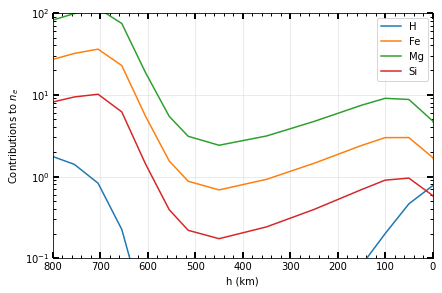

In [53]:
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax.set_yscale("log")
ax.set_xlim([800,0])
ax.set_ylim([0.1,10**2])
ax.plot(df["h"],n_p/n_e,label="H")
ax.plot(df["h"],n_Fe/n_e,label="Fe")
ax.plot(df["h"],n_Mg/n_e,label="Mg")
ax.plot(df["h"],n_Si/n_e,label="Si")
# ax.plot(df["h"],Pe,label=r"$P_{e,\mathrm{ideal}}$")
# ax.plot(df["h"],Pe_true,label=r"$P_{e,\mathrm{true}}$")

ax.set_xlabel("h (km)")
ax.set_ylabel(r"Contributions to $n_e$")

ax.legend()

output_file = "plots/18c.pdf"

fig.savefig(output_file,bbox_inches='tight')

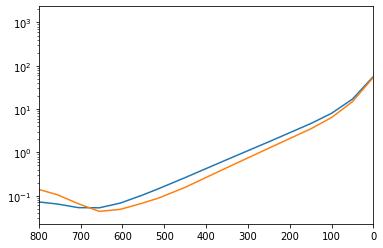

In [28]:
plt.xlim([800,0])
#plt.ylim([-10,150])
plt.yscale("log")
plt.plot(df["h"],Pe)
plt.plot(df["h"],Pe_true)

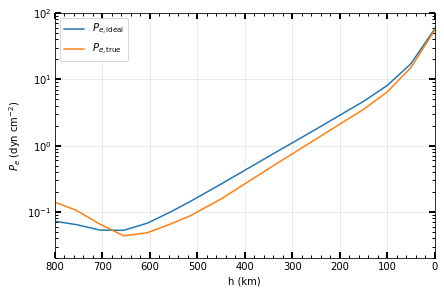

In [29]:
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/19a.pdf"
#label = r"$T = $"+str((T*u.g/u.g).value*u.K)+r" | log $P_g = $"+str(round(np.log10((Pg*u.g/u.g).value),2))+r" | log $P_e = $"+str(round(np.log10(Pe_arr[-1].value),2))
#ax.plot(i_arr,Pe_arr,lw=3,label=label)

ax.set_yscale("log")
ax.set_xlim([800,0])
ax.set_ylim([0.02,10**2])
ax.plot(df["h"],Pe,label=r"$P_{e,\mathrm{ideal}}$")
ax.plot(df["h"],Pe_true,label=r"$P_{e,\mathrm{true}}$")

ax.set_xlabel("h (km)")
ax.set_ylabel(r"$P_e$ (dyn cm$^{-2}$)")

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

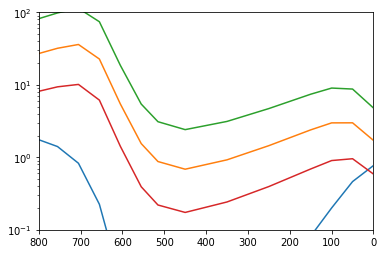

In [30]:
plt.xlim([800,0])
plt.ylim([.1,100])
plt.yscale("log")
plt.plot(df["h"],n_p/n_e)
plt.plot(df["h"],n_Fe/n_e)
plt.plot(df["h"],n_Mg/n_e)
plt.plot(df["h"],n_Si/n_e)

In [31]:
(6420*u.K*const.k_B*df.loc[df["h"]==0].n_e.to_numpy()[0]*u.cm**-3).to(u.dyn/u.cm**2)

<Quantity 57.02061041 dyn / cm2>

In [32]:
sAjm=(2.2701*10**-24*u.g)

In [33]:
astro530.stim_em_coeff(wavelength=5000*u.Angstrom,T=6420*u.K)

0.9886916789247833

In [34]:
astro530.k_Hnbf(Pe=57*u.dyn/u.cm**2,T=6420*u.K,wavelength=5000*u.Angstrom)/sAjm

<Quantity 0.63401812 dyn / g>

In [35]:
astro530.k_e(Pe=57*u.dyn/u.cm**2,Pg=1.137e5*u.dyn/u.cm**2,species=["H","Fe","Mg","Si"])/sAjm

<Quantity 0.0001469 cm2 / g>

In [36]:
1.137e5*u.dyn/u.cm**2

<Quantity 113700. dyn / cm2>

In [37]:
astro530.k_total(Pe=57*u.dyn/u.cm**2,T=6420*u.K,wavelength=5000*u.Angstrom,species=["H","Fe","Mg","Si"])/sAjm

<Quantity 0.67280628 cm2 / g>

In [38]:
astro530.true_Pe(species=spec,T=6420*u.K,Pg = 1.137e5*u.dyn/u.cm**2,single=True)

<Quantity 54.55929459 dyn / cm2>

In [39]:
reload(astro530)

<module 'src.astro530' from 'C:\\Users\\xkncr\\Documents\\PSU\\Astro530\\src\\astro530.py'>

In [40]:
true_Pe = astro530.true_Pe

In [41]:
k_total = astro530.k_total

In [42]:
def k_cont(wavelength=5000*u.Angstrom,T=5000*u.K,n_e=6e14*u.cm**-3,species="H",Pg=20*u.dyn/u.cm**2,print_bool = False,**kwargs):
    sAjmu = 0
    try:
        ab_df
    except:
        try:
            ab_df = pd.read_csv("data/SolarAbundance.csv").fillna("-")
        except:
            ab_df = pandas.read_csv("../data/SolarAbundance.csv").fillna("-")
    
    amu = (const.N_A)**-1*1*u.g/u.mol        
    
    if species == "all":
        species = []
        for element in ab_df.element:
            A = (ab_df.loc[ab_df.element == element].A).values[0]
            if A != "-" and A > 1e-10:
                species.append(element)
    
    try:
        for ele in species:
            try:
                df_e = ab_df.loc[ab_df["element"]==ele]
                A = df_e.A.to_numpy()[0]
                mu = df_e.weight.to_numpy()[0]
                sAjmu += A*mu
            except:
                raise ValueError(ele+" is not a valid element")
    except:
        try:
            df_e = ab_df.loc[ab_df["element"]==species]
            A = df_e.A.to_numpy()[0]
            mu = df_e.weight.to_numpy()[0]
            sAjmu += A*mu
        except:
            raise ValueError(ele+" is not a valid element")
    Pe = true_Pe(species=species,T=T,Pg=Pg,single=True,**kwargs)
   
    K_tot = k_total(Pe=Pe,T=T,wavelength=wavelength,Pg=Pg,species=species)
    
    if print_bool:
        print("T =",T)
        print("P_e =",Pe)
        print("P_g =",Pg)
        print("Wavelength =",wavelength)
        print("Mean particle mass =",sAjmu*amu)
        print("Opacity =",K_tot/sAjmu/amu)
        
    
    return K_tot/sAjmu/amu
def k_alt(wavelength=5000*u.Angstrom,T=5000*u.K,Pe=50*u.dyn/u.cm**2,Pg=2e5*u.dyn/u.cm**2,print_bool = False,**kwargs):
    sAjmu = 0
    try:
        ab_df
    except:
        try:
            ab_df = pd.read_csv("data/SolarAbundance.csv").fillna("-")
        except:
            ab_df = pandas.read_csv("../data/SolarAbundance.csv").fillna("-")
    
    amu = (const.N_A)**-1*1*u.g/u.mol        
    
    species = []
    for element in ab_df.element:
        A = (ab_df.loc[ab_df.element == element].A).values[0]
        if A != "-" and A > 1e-10:
            species.append(element)
    
    for ele in species:
        df_e = ab_df.loc[ab_df["element"]==ele]
        A = df_e.A.to_numpy()[0]
        mu = df_e.weight.to_numpy()[0]
        sAjmu += A*mu
   
    K_tot = k_total(Pe=Pe,T=T,wavelength=wavelength,Pg=Pg,species=species)
    
    if print_bool:
        print("T =",T)
        print("P_e =",Pe)
        print("P_g =",Pg)
        print("Wavelength =",wavelength)
        print("Mean particle mass =",sAjmu*amu)
        print("Opacity =",K_tot/sAjmu/amu)
        
    
    return K_tot/sAjmu/amu

In [43]:
k_cont(wavelength=5000*u.Angstrom,T=6420*u.K,Pg=1.13e5*u.dyn/u.cm**2,n_e=6.433e13*u.cm**-3,species="all",print_bool=True)

T = 6420.0 K
P_e = 55.751516426331875 dyn / cm2
P_g = 113000.0 dyn / cm2
Wavelength = 5000.0 Angstrom
Mean particle mass = 2.270136654501767e-24 g
Opacity = 0.6584006101279974 cm2 / g


<Quantity 0.65840061 cm2 / g>

In [44]:
k_alt(wavelength=5000*u.Angstrom,T=6420*u.K,Pe=57*u.Ba,Pg=1.13e5*u.Ba,print_bool=True)

T = 6420.0 K
P_e = 57.0 Ba
P_g = 113000.0 Ba
Wavelength = 5000.0 Angstrom
Mean particle mass = 2.270136654501767e-24 g
Opacity = 0.6729559487899747 cm2 / g


<Quantity 0.67295595 cm2 / g>

In [45]:
df.loc[df.h==0]

,h,m,tau_500,T,V,n_H,n_e,Ptotal,Pgas/Ptotal,rho
48,0.0,4.279,0.9953,6420.0,1.6,1.166000e+17,6.433000e+13,117200.0,0.9702,2.727000e-07


In [46]:
k_total(wavelength=5000*u.Angstrom,T=6420*u.K,Pg=1.13e5*u.dyn/u.cm**2,Pe=57*u.bar,species=["H","Fe","Mg","Si"])

<Quantity 1.50820778e-18 cm2>

In [47]:
(true_Pe(species=["H","Fe","Mg","Si"],T=6420*u.K,Pg=1.13e5*u.dyn/u.cm**2,single=True)/(6.43e13*u.cm**-3*const.k_B)).cgs

<Quantity 6405.85558582 K>